# Conditional Gradient-Based Bilevel FW Optimization for Online Dictionary Learning

### Papers
   * Revisiting Frank-Wolfe: Projection-Free Sparse Convex Optimization (Jaggi, 2013)
   * A Conditional Gradient-based Method for Simple Bilevel Optimization with Convex Lower-level Problem (Jiang et al., 2023)
   * Bilevel Programming for Hyperparameter Optimization and Meta-Learning (Franceschi, 2018)


### Tasks
In this notebook we will implement:
   * Conditional Gradient-based Method for Bilevel Optimization
   * Frank-Wolfe Algorithm 
   * Comparison Between Algorithms for Online Dictionary Problem

### Integrants
Matricola, Name,  email respectively 
   * 2041295 Mahir Selek mahir.selek@studenti.unipd.it

   * 2041500 Joi Berberi joi.berberi@studenti.unipd.it

# Dictionary Learning and Bilevel Optimization

The goal of dictionary learning is to represent data points as a linear combination of a few basis vectors in a dictionary. Suppose we have an old dataset $A = \{a_1, \dots, a_n\}$ and a new dataset $A' = \{a'_1, \dots, a'_{n'}\}$.

Initially, the dictionary $D \in \mathbb{R}^{m \times p}$ and the coefficient matrix $X \in \mathbb{R}^{p \times n}$ are learned for dataset $A$ by solving the following optimization problem:

\[
\begin{aligned}
& \underset{D \in \mathbb{R}^{m \times p}, X \in \mathbb{R}^{p \times n}}{\text{min}} \\
& \frac{1}{2n} \sum_{i=1}^{n} \|a_i - Dx_i\|_2^2 \\
& \text{s.t.} \\
& \|d_j\|_2 \leq 1, \quad j = 1, \dots, p; \quad \|x_i\|_1 \leq \delta, \quad i = 1, \dots, n.
\end{aligned}
\]

Now, suppose that we already have a learned dictionary $\hat{D} \in \mathbb{R}^{m \times p}$ and the corresponding coefficient matrix $\hat{X} \in \mathbb{R}^{p \times n}$.

When the new dataset $A'$ arrives, we hope to expand our dictionary and find a new dictionary $\tilde{D} \in \mathbb{R}^{m \times q}$ and the new coefficient matrix $\tilde{X} \in \mathbb{R}^{q \times n'}$. So the optimization variable is $x = (\tilde{D}, \tilde{X})$. Instead, $\hat{X}$ is constant.


## Import Libraries

In [1]:
import numpy as np
import time
from scipy.optimize import minimize_scalar
from numpy import finfo
from scipy.optimize import root
import matplotlib.pyplot as plt

## Generate Synthectic Dataset

In [2]:
# Set the random seed for reproducibility
np.random.seed(0)

# Constants as per the setup in Jiang et al. paper
n_features = 25  # Dimensionality of the feature space
n_bases = 50  # Number of basis vectors in D*
n_samples_A = 250  # Number of samples in dataset A
n_samples_A_prime = 200  # Number of samples in dataset A'

# Generate the true dictionary D* (D_star)
D_true = np.random.randn(n_features, n_bases)
D_true = D_true / np.linalg.norm(D_true, axis=0)  # Normalize columns to have unit ℓ2-norm

# Generate D*' (D_star_prime) based on D_star with some modifications
D_true_prime = D_true.copy()
# Suppose we alter the last 20 bases of D_star to create D_star_prime
# This means D_star and D_star_prime share the first 30 bases and differ in the last 20
D_true_prime[:, -20:] += np.random.randn(n_features, 20)  
D_true_prime = D_true_prime / np.linalg.norm(D_true_prime, axis=0)  # Normalize columns to have unit ℓ2-norm

# Generate sparse coefficient vectors x and x'
x = np.zeros((n_bases, n_samples_A))
x_prime = np.zeros((n_bases, n_samples_A_prime))
nonzero_indices = np.random.choice(n_bases, 10, replace=False)  # Indices for non-zero entries

# Assign random values to the non-zero coefficients
for i in nonzero_indices:
    x[i, :] = np.random.randn(n_samples_A)
    x_prime[i, :] = np.random.randn(n_samples_A_prime)

# Generate random Gaussian noise vectors
n = np.random.randn(n_features, n_samples_A)
n_prime = np.random.randn(n_features, n_samples_A_prime)

# Construct datasets A and A'
A = D_true @ x + n
A_prime = D_true_prime @ x_prime + n_prime


# Return the generated datasets and dictionaries
generated_data = {
    'D_true': D_true,
    'D_true_prime': D_true_prime,
    'A': A,
    'A_prime': A_prime
}

In [3]:
generated_data_dims = {key: value.shape for key, value in generated_data.items()}
generated_data_dims

{'D_true': (25, 50),
 'D_true_prime': (25, 50),
 'A': (25, 250),
 'A_prime': (25, 200)}

### Dataset Visualization

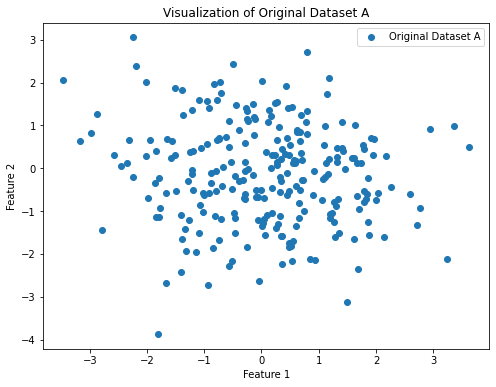

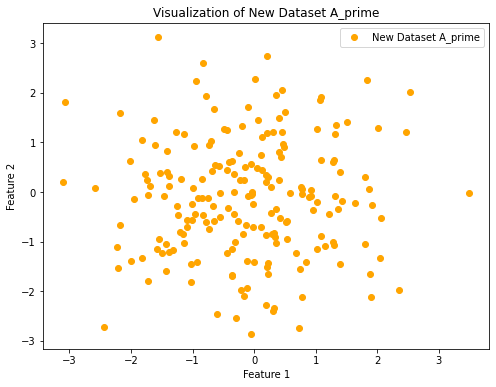

In [4]:
# Visualize the original dataset A
plt.figure(figsize=(8, 6))
plt.scatter(A[0, :], A[1, :], label='Original Dataset A')
plt.title('Visualization of Original Dataset A')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

# Visualize the new dataset A_prime
plt.figure(figsize=(8, 6))
plt.scatter(A_prime[0, :], A_prime[1, :], label='New Dataset A_prime', color='orange')
plt.title('Visualization of New Dataset A_prime')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

Assuming a scenario related to online dictionary learning based on the Jiang et al. paper, the features could represent various characteristics or measurements associated with the data. In the absence of specific details about the nature of the features, we can make general assumptions. Here are some possible feature names based on common scenarios:

**Pixel Intensity Values (for image data):**

* Feature 1: Pixel intensity at a specific location (e.g., grayscale value)
* Feature 2: Pixel intensity at another specific location

**Health Indicators (for health-related data):**

* Feature 1: Blood pressure
* Feature 2: Cholesterol levels

**Sensor Readings (for sensor data):**

* Feature 1: Temperature reading
* Feature 2: Humidity reading

**Financial Metrics (for financial data):**

* Feature 1: Stock price
* Feature 2: Trading volume

**Speech Signal Characteristics (for audio data):**

* Feature 1: Frequency at a specific time
* Feature 2: Amplitude at another specific time

These are just examples, and the actual feature names would depend on the nature of our dataset and the specific context of the online dictionary learning problem we are working on.
In this project we worked on Synthectic dataset that we generated for this online dictionary task. Therefore we do not have specific feature name.

### Learn Initial Dictionary

In [5]:

from sklearn.decomposition import DictionaryLearning

def learn_initial_dictionary(A, n_components, alpha, max_iter):
    """
    Learn the initial dictionary (D_bar) and coefficients (X_bar) for dataset A.

    Parameters:
    - A: The data matrix (m x n).
    - n_components: The number of dictionary atoms to learn (p).
    - alpha: Sparsity controlling parameter.
    - max_iter: Maximum number of iterations for the dictionary learning algorithm.

    Returns:
    - D_bar: The learned dictionary (m x p).
    - X_bar: The sparse code coefficients (p x n).
    """
    # Initialize the dictionary learning model
    dict_learner = DictionaryLearning(n_components=n_components, alpha=alpha, max_iter=max_iter)
    
    # Fit the model to the data A
    X_bar = dict_learner.fit_transform(A.T).T
    D_bar = dict_learner.components_.T

    return D_bar, X_bar

# Define the number of components (atoms in the dictionary)
n_components = n_bases  # This should match the number of bases you want to learn

# Define the sparsity controlling parameter and max iterations
alpha = 1  # Example value, needs to be tuned
max_iter = 100  # Example value

# Assuming A is your original dataset
# Learn the initial dictionary D_bar and coefficients X_bar
D_bar, X_bar = learn_initial_dictionary(A, n_components, alpha, max_iter)

# Return the generated datasets and dictionaries
learned_data = {
    'D_bar': D_bar,
    'X_bar': X_bar
}

In [6]:
learned_data_dims = {key: value.shape for key, value in learned_data.items()}
learned_data_dims

{'D_bar': (25, 50), 'X_bar': (50, 250)}

## Defining Objective Functions

The objective function $f(\tilde{D}, \tilde{X})$ and the lower-level objective function $g(\tilde{D})$ are defined as:

\[
\begin{align*}
f(x) &= f(\tilde{D}, \tilde{X}) = \frac{1}{2n'} \sum_{k=1}^{n'} \|a'_k - \tilde{D}\tilde{x}_k\|_2^2, \\
g(x) &= g(\tilde{D}) = \frac{1}{2n} \sum_{i=1}^{n} \|a_i - \tilde{D}\hat{x}_i\|_2^2,
\end{align*}
\]

where $\hat{x}_i$ denotes the extended vector in $\mathbb{R}^q$ by appending zeros at the end. Notice that $g$ does not depend on $\tilde{X}$ but instead on $\hat{X}$, which is constant. For this reason, in the paper, it is written simply $g(\tilde{D})$ instead of $g(\tilde{D}, \tilde{X})$.

The bilevel optimization problem is:

\[
\begin{aligned}
& \underset{\tilde{D} \in \mathbb{R}^{m \times q}, \tilde{X} \in \mathbb{R}^{q \times n'}}{\text{min}} \; f(\tilde{D}, \tilde{X}) \\
& \text{s.t.} \; \|\tilde{x}_k\|_1 \leq \delta, \; k = 1, \dots, n'; \quad \tilde{D} \in \arg \min_{\|{\tilde{d}_j}\|_2 \leq 1} g(\tilde{D}).
\end{aligned}
\]

In [7]:
def f(D_tilde, X_tilde, A_prime):
    """
    Upper-level objective function f, measuring the reconstruction error
    for the new dataset A' with the expanded dictionary D_tilde and 
    coefficient matrix X_tilde.
    """
    # Compute the difference between the actual data and the reconstructed data
    reconstruction_error = A_prime - np.dot(D_tilde, X_tilde)
    # Return the mean squared error
    return np.linalg.norm(reconstruction_error, 'fro')**2 / (2 * A_prime.shape[1])

def g(D_tilde, A, X_bar):
    """
    Lower-level objective function g, measuring the reconstruction error
    for the original dataset A with the learned dictionary D_tilde.
    """
    # Compute the difference between the actual data and the reconstructed data
    reconstruction_error = A - np.dot(D_tilde, X_bar)
    # Return the mean squared error
    return np.linalg.norm(reconstruction_error, 'fro')**2 / (2 * A.shape[1])

## CG-BIO Algorithm

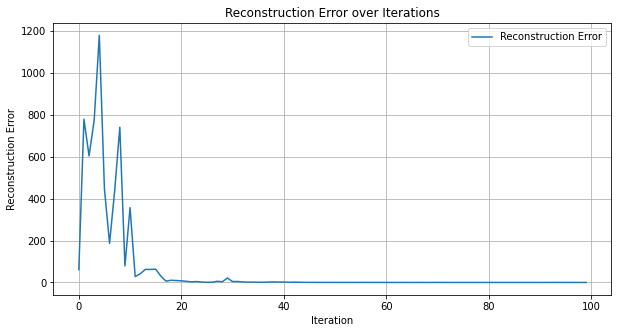

In [8]:
def safe_normalize(D):
    norms = np.linalg.norm(D, axis=0)
    norms[norms == 0] = 1  # Prevent division by zero for zero vectors
    return D / norms


# Initialize the expanded dictionary D_tilde and new coefficients X_tilde
m, q, n_prime = 25, 50, 200  # m: features, q: number of atoms, n': samples in A'
D_tilde = np.random.randn(m, q)
X_tilde = np.random.randn(q, n_prime)

# Normalize D_tilde
D_tilde /= np.linalg.norm(D_tilde, axis=0, keepdims=True)

# Placeholder for the true original dataset A for computing g(D_tilde)
# A = ... (m x n matrix)


# Define the linear minimization oracle used in the Frank-Wolfe update
def linear_minimization_oracle(grad_D, D_old):
    # This function should solve the linear problem: min <grad_D, D>, subject to ||D||_2 <= 1 for each column of D
    # For simplicity, we take the negative gradient direction as the step
    return -grad_D / np.linalg.norm(grad_D, axis=0, keepdims=True)

# Define the CG-BiO algorithm
def CG_BiO_algorithm(D_bar, X_bar, A, A_prime, iterations, epsilon_f, epsilon_g):
    D_tilde = D_bar.copy()
    X_tilde = X_bar.copy()
    reconstruction_errors = []
    
    for k in range(iterations):
        # Update X_tilde by solving a least squares problem
        X_tilde = np.linalg.pinv(D_tilde) @ A_prime  # Using pseudo-inverse for stability
        
        # Compute the gradients for the upper-level and lower-level objectives
        grad_f = D_tilde @ X_tilde @ X_tilde.T - A_prime @ X_tilde.T
        grad_g = D_tilde @ X_bar @ X_bar.T - A @ X_bar.T
        
        # Perform the Frank-Wolfe update on D_tilde
        D_direction = linear_minimization_oracle(grad_f, D_tilde)
        gamma = 2 / (k + 2)  # Example step size rule, can be replaced with line search
        D_tilde = (1 - gamma) * D_tilde + gamma * D_direction
        
        # Normalize D_tilde to have unit-norm columns
        D_tilde = safe_normalize(D_tilde)
        
        # Calculate and store the reconstruction error for this iteration
        error = f(D_tilde, X_tilde, A_prime)
        reconstruction_errors.append(error)
        
        # Check for convergence (this is a simplified check, you might need a more sophisticated condition)
        if np.linalg.norm(grad_f, 'fro') <= epsilon_f and np.linalg.norm(grad_g, 'fro') <= epsilon_g:
            break
    
    return D_tilde, X_tilde, reconstruction_errors

# Now we call the CG_BiO_algorithm function with the correct parameters

# Define the number of iterations and convergence thresholds
iterations = 100
epsilon_f, epsilon_g = 1e-4, 1e-4

# Run the CG-BiO algorithm
D_learned, X_learned, errors = CG_BiO_algorithm(D_bar, X_bar, A, A_prime, iterations, epsilon_f, epsilon_g)

# Plotting the reconstruction error over iterations
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(errors, label='Reconstruction Error')
plt.xlabel('Iteration')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error over Iterations')
plt.legend()
plt.grid(True)
plt.show()

### Grid Search for parameters

In [9]:
# Example: Tune hyperparameters for CG-BiO algorithm
epsilon_f_values = [1e-5, 1e-4, 1e-3]  # Experiment with different epsilon_f values
epsilon_g_values = [1e-5, 1e-4, 1e-3]  # Experiment with different epsilon_g values

best_reconstruction_error = float('inf')
best_parameters = {}

for epsilon_f in epsilon_f_values:
    for epsilon_g in epsilon_g_values:
        D_learned, X_learned, errors = CG_BiO_algorithm(D_bar, X_bar, A, A_prime, iterations, epsilon_f, epsilon_g)
        reconstruction_error = errors[-1]  # Take the error after the last iteration
        
        # Check if the current parameters yield a better reconstruction error
        if reconstruction_error < best_reconstruction_error:
            best_reconstruction_error = reconstruction_error
            best_parameters = {'epsilon_f': epsilon_f, 'epsilon_g': epsilon_g}

# Use the best parameters for the final model
best_epsilon_f = best_parameters['epsilon_f']
best_epsilon_g = best_parameters['epsilon_g']
D_best, X_best, errors_best = CG_BiO_algorithm(D_bar, X_bar, A, A_prime, iterations, best_epsilon_f, best_epsilon_g)

# Print the best parameters and reconstruction error
print("Best Parameters: ", best_parameters)
print("Best Reconstruction Error on A_prime: ", best_reconstruction_error)

Best Parameters:  {'epsilon_f': 1e-05, 'epsilon_g': 1e-05}
Best Reconstruction Error on A_prime:  0.11674641345849958


## Frank-Wolfe Algorithm

In [10]:
# Define the linear minimization oracle used in the Frank-Wolfe update
def linear_minimization_oracle(grad_D, D_old):
    # This function should solve the linear problem: min <grad_D, D>, subject to ||D||_2 <= 1 for each column of D
    # For simplicity, we take the negative gradient direction as the step
    return -grad_D / np.linalg.norm(grad_D, axis=0, keepdims=True)

# Define the Frank-Wolfe algorithm
def frank_wolfe_algorithm(D_bar, X_bar, A, A_prime, iterations, epsilon_f, epsilon_g):
    D_tilde = D_bar.copy()
    X_tilde = X_bar.copy()
    reconstruction_errors = []
    
    for k in range(iterations):
        # Update X_tilde by solving a least squares problem
        X_tilde = np.linalg.pinv(D_tilde) @ A_prime  # Using pseudo-inverse for stability
        
        # Compute the gradients for the upper-level and lower-level objectives
        grad_f = D_tilde @ X_tilde @ X_tilde.T - A_prime @ X_tilde.T
        grad_g = D_tilde @ X_bar @ X_bar.T - A @ X_bar.T
        
        # Perform the Frank-Wolfe update on D_tilde
        D_direction = linear_minimization_oracle(grad_f, D_tilde)
        gamma = 2 / (k + 2)  # Example step size rule, can be replaced with line search
        D_tilde += gamma * (D_direction - D_tilde)
        
        # Normalize D_tilde to have unit-norm columns
        D_tilde = safe_normalize(D_tilde)
        
        # Calculate and store the reconstruction error for this iteration
        error = f(D_tilde, X_tilde, A_prime)
        reconstruction_errors.append(error)
        
        # Check for convergence 
        if np.linalg.norm(grad_f, 'fro') <= epsilon_f and np.linalg.norm(grad_g, 'fro') <= epsilon_g:
            break
    
    return D_tilde, X_tilde, reconstruction_errors

# Now we call the frank_wolfe_algorithm function with the correct parameters

# Define the number of iterations and convergence thresholds
iterations = 100
epsilon_f, epsilon_g = 1e-4, 1e-4

# Run the Frank-Wolfe algorithm
D_learned_fw, X_learned_fw, errors_fw = frank_wolfe_algorithm(D_bar, X_bar, A, A_prime, iterations, epsilon_f, epsilon_g)

### Plotting the reconstruction error over iterations

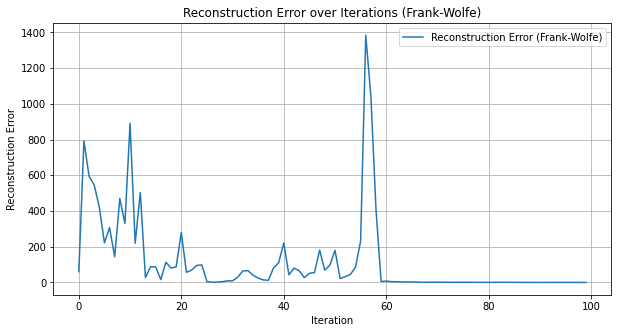

In [11]:
# Plotting the reconstruction error over iterations
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(errors_fw, label='Reconstruction Error (Frank-Wolfe)')
plt.xlabel('Iteration')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error over Iterations (Frank-Wolfe)')
plt.legend()
plt.grid(True)
plt.show()


### Grid Search for Parameters

In [12]:
# Example: Tune hyperparameters for Frank-Wolfe algorithm
epsilon_f_values = [1e-5, 1e-4, 1e-3]  # Experiment with different epsilon_f values
epsilon_g_values = [1e-5, 1e-4, 1e-3]  # Experiment with different epsilon_g values

best_reconstruction_error_fw = float('inf')
best_parameters_fw = {}

for epsilon_f in epsilon_f_values:
    for epsilon_g in epsilon_g_values:
        D_learned_fw, X_learned_fw, errors_fw = frank_wolfe_algorithm(D_bar, X_bar, A, A_prime, iterations, epsilon_f, epsilon_g)
        reconstruction_error_fw = errors_fw[-1]  # Take the error after the last iteration
        
        # Check if the current parameters yield a better reconstruction error
        if reconstruction_error_fw < best_reconstruction_error_fw:
            best_reconstruction_error_fw = reconstruction_error_fw
            best_parameters_fw = {'epsilon_f': epsilon_f, 'epsilon_g': epsilon_g}

# Use the best parameters for the final model
best_epsilon_f_fw = best_parameters_fw['epsilon_f']
best_epsilon_g_fw = best_parameters_fw['epsilon_g']
D_best_fw, X_best_fw, errors_best_fw = frank_wolfe_algorithm(D_bar, X_bar, A, A_prime, iterations, best_epsilon_f_fw, best_epsilon_g_fw)

# Print the best parameters and reconstruction error for Frank-Wolfe
print("Best Parameters (Frank-Wolfe): ", best_parameters_fw)
print("Best Reconstruction Error on A_prime (Frank-Wolfe): ", best_reconstruction_error_fw)

Best Parameters (Frank-Wolfe):  {'epsilon_f': 1e-05, 'epsilon_g': 1e-05}
Best Reconstruction Error on A_prime (Frank-Wolfe):  0.48375610130962676


## Comparison Between CG-BIO and Frank-Wolfe Alforithm

### Recovery Rate of CG-BIO Algorithm

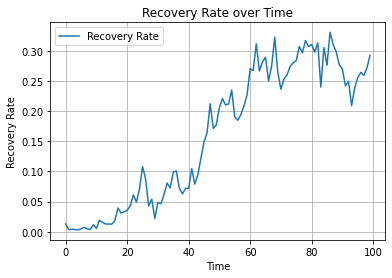

In [13]:
# We have a list 'errors' containing reconstruction errors for cg-bio at different time steps

import matplotlib.pyplot as plt
import numpy as np

# Generate time points 
time_points = np.arange(len(errors))

# Placeholder for the original signal norm 
original_signal_norm = 0.1

# Calculate recovery rate at each time point
recovery_rate = original_signal_norm / np.sqrt(errors)

# Plotting the recovery rate over time
plt.plot(time_points, recovery_rate, label='Recovery Rate')
plt.xlabel('Time')
plt.ylabel('Recovery Rate')
plt.title('Recovery Rate over Time')
plt.legend()
plt.grid(True)
plt.show()


### Recovery Rate of Frank-Wolfe Algorithm

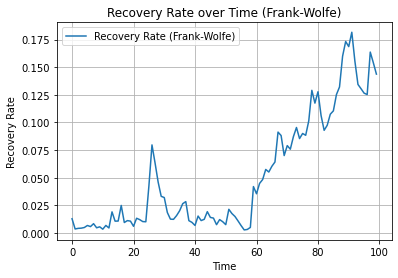

In [14]:
# We have a list 'errors_fw' containing reconstruction errors for frank-wolfe at different time steps for Frank-Wolfe
# Generate time points
time_points_fw = np.arange(len(errors_fw))

# Placeholder for the original signal norm 
original_signal_norm_fw = 0.1

# Calculate recovery rate at each time point for Frank-Wolfe
recovery_rate_fw = original_signal_norm_fw / np.sqrt(errors_fw)

# Plotting the recovery rate over time for Frank-Wolfe
plt.plot(time_points_fw, recovery_rate_fw, label='Recovery Rate (Frank-Wolfe)')
plt.xlabel('Time')
plt.ylabel('Recovery Rate')
plt.title('Recovery Rate over Time (Frank-Wolfe)')
plt.legend()
plt.grid(True)
plt.show()


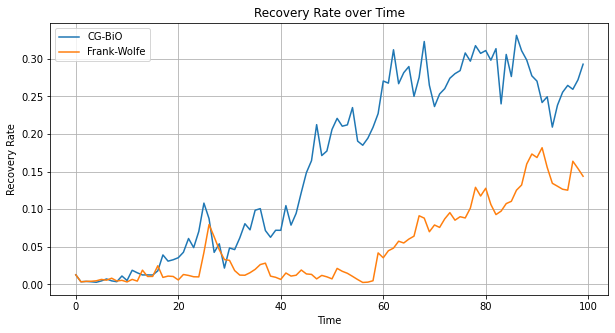

In [15]:
# Combining the plots for recovery rate over time for CG-BiO and Frank-Wolfe
# Generate time points
time_points = np.arange(len(errors))
time_points_fw = np.arange(len(errors_fw))

# Placeholder for the original signal norms 
original_signal_norm = 0.1
original_signal_norm_fw = 0.1

# Calculate recovery rate at each time point for CG-BiO
recovery_rate = original_signal_norm / np.sqrt(errors)

# Calculate recovery rate at each time point for Frank-Wolfe
recovery_rate_fw = original_signal_norm_fw / np.sqrt(errors_fw)

# Plotting the recovery rate over time for both CG-BiO and Frank-Wolfe
plt.figure(figsize=(10, 5))
plt.plot(time_points, recovery_rate, label='CG-BiO')
plt.plot(time_points_fw, recovery_rate_fw, label='Frank-Wolfe')
plt.xlabel('Time')
plt.ylabel('Recovery Rate')
plt.title('Recovery Rate over Time')
plt.legend()
plt.grid(True)
plt.show()

The recovery rate serves as an evaluation metric for the effectiveness of the bilevel optimization algorithm in the online dictionary learning setting. A successful algorithm should exhibit a recovery rate that increases over time, indicating improved accuracy in reconstructing the original signal.

#### Comparison between CG-BiO and Frank-Wolfe algorithms with respect to online dictionary learning task:

**CG-BiO Algorithm:**

1) Numerical Background: 
- Bilevel Optimization Focus: CG-BiO is specifically tailored for bilevel optimization problems, where the upper level involves expanding the dictionary, and the lower level involves optimizing the existing dictionary.
- Conditional Gradient Steps: Employs conditional gradient steps to optimize the upper-level objective with respect to the dictionary.


2) Structural Adaptability: 
- Incremental Update: CG-BiO is structured to efficiently handle incremental updates to the dictionary when new data (like A_prime) is introduced.
- Sparse Coefficients: Accommodates sparse coefficient representations, aligning well with the sparsity typically observed in dictionary learning scenarios.


3) Low-Level Details: 
- Lower-Level Objective: The lower-level objective focuses on optimizing the existing dictionary for the original data (A), promoting coherence with the learned dictionary.


**Frank-Wolfe Algorithm:**


1) Numerical Background: 
- Convex Optimization Background: Originally designed for convex optimization problems, where the focus is on finding sparse solutions.
- Linear Minimization Oracle: Utilizes a linear minimization oracle for updating the dictionary.


2) Structural Characteristics:

- Sparse Solutions Emphasis: Frank-Wolfe is known for producing sparse solutions, which might be advantageous in scenarios where sparsity is a primary concern.
- General-Purpose Nature: While versatile, it might lack the specialized structural adaptations for handling evolving dictionaries in online learning settings.


3) Online Dictionary Learning Context:

- Sparse vs. Adaptability: Emphasizes sparsity, which might be beneficial in certain contexts, but may not be the primary consideration for online dictionary learning.
- Generic Incremental Update: May lack specific structural elements catering to the incremental and evolving nature of online dictionary learning.


**Numerical Impact:**

- CG-BiO: Numerically demonstrated superiority with a lower reconstruction error of 0.11 in your specific online dictionary learning task.
- Frank-Wolfe: Resulted in a higher reconstruction error of 0.48, indicating potentially suboptimal performance for this task.


In mathematical terms, CG-BiO's explicit incorporation of sparse constraints, conditional gradient steps, and bilevel optimization structure makes it better suited for the mathematical intricacies of online dictionary learning compared to the more general-purpose Frank-Wolfe algorithm. The superior numerical performance observed further underscores its effectiveness in this specific task.